<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Principal Component Analysis with Pyleoclim

by [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751), [Deborah Khider](https://orcid.org/0000-0001-7501-8430)

## Preamble
Multivariate data reduction

### Goals

- PCA
- MC-PCA

**Reading Time: 15 min**

### Keywords
Principal Component Analysis, Singular Value Decomposition, Data Reduction

### Pre-requisites
None

### Relevant Packages
statsmodels, matplotlib, pylipd

## Data 
### Data Description

Euro2k ayayayayyyaya, PAGES 2k

### Loading
To load this dataset, we make use of [pylipd](https://pylipd.readthedocs.io). We first import everything into a pandas dataframe:

In [1]:
%load_ext autoreload
%autoreload 2
from pylipd.utils.dataset import load_dir
lipd = load_dir(name='Euro2k')
df = lipd.get_timeseries_essentials()

Loading 31 LiPD files


100%|██████████| 31/31 [00:00<00:00, 62.69it/s]


Loaded..


Next, let's select all the tree-ring data from this network:

In [2]:
dfs = df.query("archiveType in ('tree')") 
len(dfs)

34

Next, we iterate over the rows of this dataframe, create GeoSeries objects for each proxy record, and bundle them all into a MultipleGeoSeries object:


In [3]:
import pyleoclim as pyleo
ts_list = []
for _, row in dfs.iterrows():
    ts_list.append(pyleo.GeoSeries(time=row['time_values'],value=row['paleoData_values'],
                                   time_name=row['time_variableName'],value_name=row['paleoData_variableName'],
                                   time_unit=row['time_units'], value_unit=row['paleoData_units'],
                                   lat = row['geo_meanLat'], lon = row['geo_meanLon'],
                                   archiveType = row['archiveType'], verbose = False, 
                                   label=row['dataSetName']+'_'+row['paleoData_variableName'])) 

Euro2k = pyleo.MultipleGeoSeries(ts_list, label='Euro2k', time_unit='year AD')  
len(Euro2k)

34

Let's map these records all at once:

(<Figure size 640x480 with 1 Axes>, <GeoAxes: >)

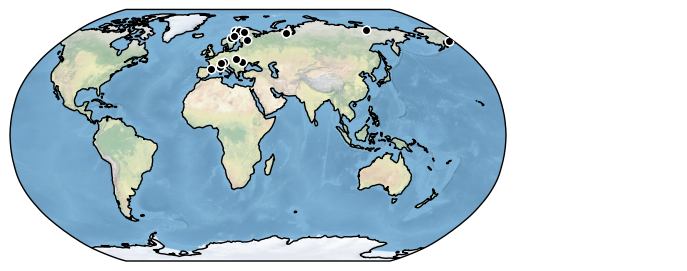

In [4]:
Euro2k.map()

BUG: No legend.  

The default projection is "Robinson" because it is a visually pleasing balance between distorting areas or length (no 2D projection of a 3D object can preserve both). However, there would be more suitable choices for this latitude range. For instance:

(<Figure size 640x480 with 1 Axes>, <GeoAxes: >)

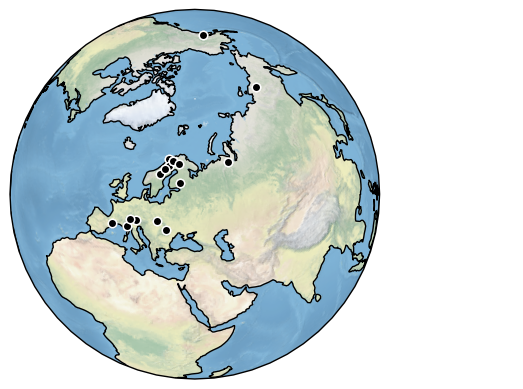

In [5]:
Euro2k.map(projection='Orthographic')

For a full list of allowable projections, see the [cartopy documentation](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html).

## Principal Component Analysis

Now let's perform PCA. To do this, all the Series objects within the collection must be on a common time axis, and it's also prudent to standardize them so differences in units don't mess up the scaling of the data matrix on which PCA operates. We can perform both operations at once using method-chaining:

In [6]:
Euro2kc = Euro2k.common_time().standardize()

The PCA part is extremely anticlimatic:

In [20]:
pca = Euro2kc.pca()
type(pca)

pyleoclim.core.multivardecomp.MultivariateDecomp

Here, we placed the result of the operation into an object called "pca" (we felt very inspired when we wrote this), which is of type [MultivariateDecomp]() TODO: link to docs once the class is merged into master, which contains the following information:  

In [21]:
pca.__dict__.keys()

dict_keys(['name', 'eigvals', 'eigvecs', 'pctvar', 'pcs', 'neff', 'orig', 'locs'])

- _name_ is a string used in plots
- _eigvals_ is an array containing the eigenvalues of the covariance matrix
- _pctvar_ is the % of the total variance accounted for by each mode (derived from the eigenvalues)
- _eigvecs_ is an array containing the eigenvectors of the covariance matrix ()
- _pcs_ is an array containing the temporal  loadings corresponding to these eigenvectors.
- _neff_ is an estimate of the effective sample size ("degrees of freedom") associated with the principal component. Because of autocorrelation, this number is usually much smaller than the length of the timeseries itself. 
- _orig_ is the original MultipleSeries (or MultipleGeoSeries) object on which the multivariate decomposition was applied.
- _locs_ is an array containing the geographic coordinates as (lat, lon). 

The first thing one should look at in such an object is the eigenvalue spectrum, often called a [scree plot](https://en.wikipedia.org/wiki/Scree_plot):

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Euro2k PCA eigenvalues'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

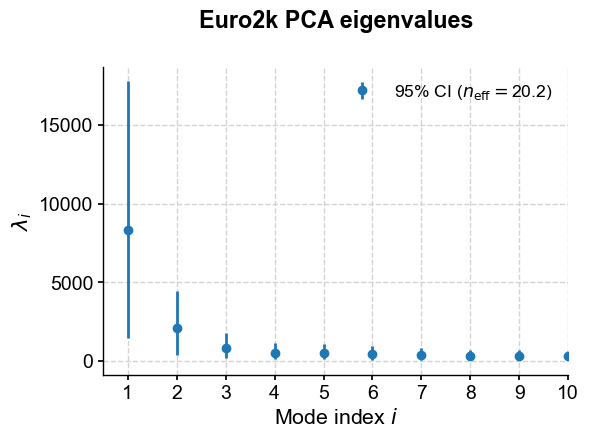

In [23]:
pca.screeplot()

As is nearly always the case with geophysical timeseries, the first handful of eigenvalues trully overwhelm the rest. We'll return to this in a second. 
Note also that, as usual in `pyleoclim`, the code uses labels that have been provided to generate the title. However, this is easy to override:

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': "Here's a dandy scree plot"}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

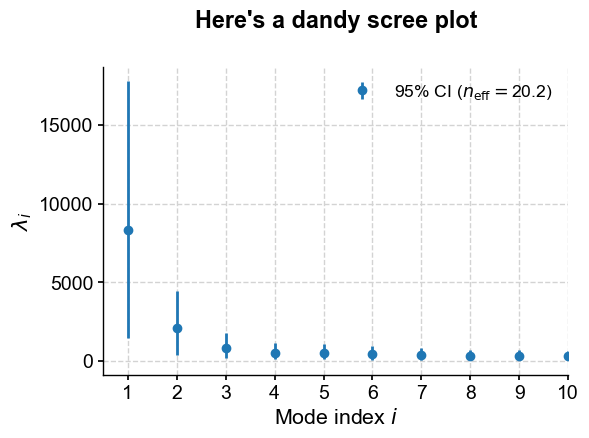

In [24]:
pca.screeplot(title="Here's a dandy scree plot")

Eigenvalues are, by themselves, not all that informative; their meaning comes from the fact that their normalized value quantifies the fraction of variance accounted for by each mode. That is readily accessed via:

In [27]:
pca.pctvar[:5] # display only the first 5 values, for brevity

array([91.68239395,  5.64257121,  0.9074062 ,  0.35122774,  0.33205552])

The first mode accounts for nearly 92% of the total variance; let's look at it via `modeplot()`

(<Figure size 800x800 with 4 Axes>, GridSpec(4, 3))

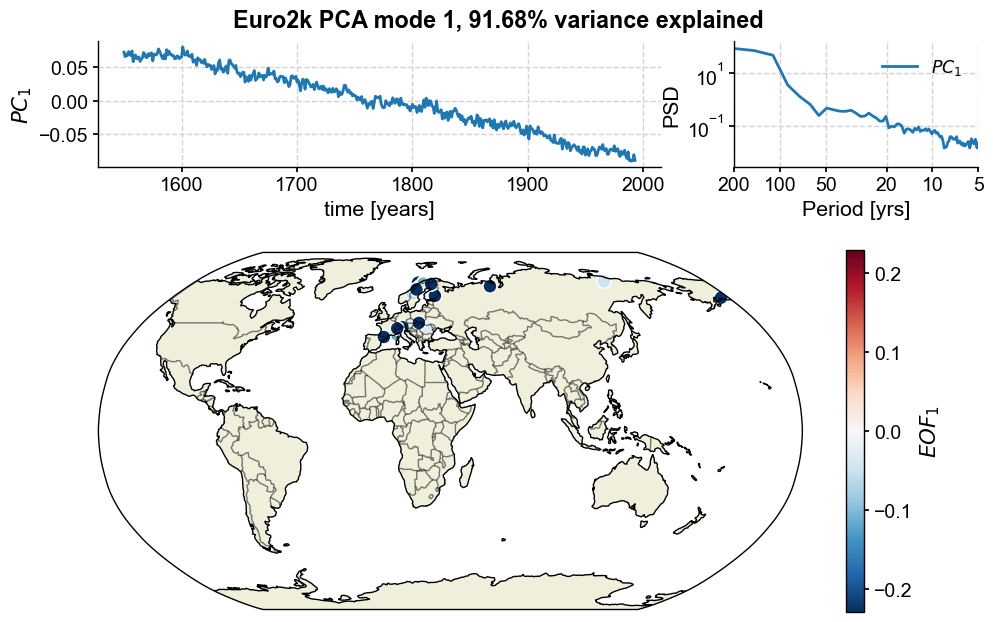

In [37]:
pca.modeplot()

Three features jump at us:
- firstly, the first principal component displays a strong linear trend, a downward one in this case. However, this does not mean anything, as the sign of a PC is arbitrary (indeed, all the spatial loadings are negative as well, so their product would be positive). It is easy to highlight by flipping the values (see below).
- the figure includes the PC's spectrum (here, using the MTM method). It is not very informative in this case of a nearly pure linear trend, but could potentially reveal behavior that is periodic or nearly so.  
- the default map projection is global, which does not make the most sense here. Let's use an orthographic projection instead:

(<Figure size 800x800 with 4 Axes>, GridSpec(4, 3))

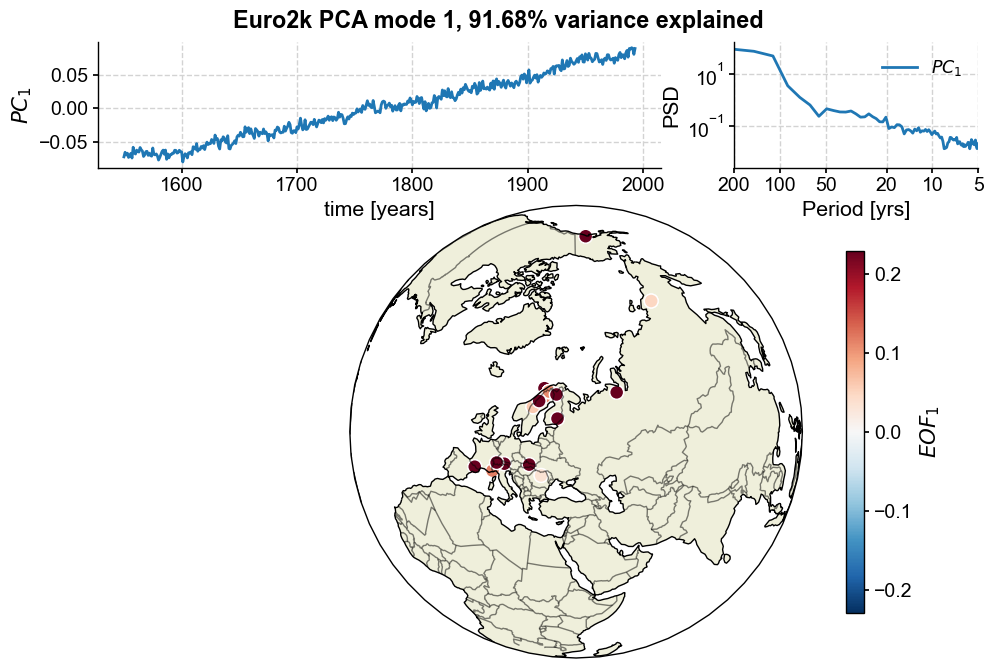

In [38]:
pca.modeplot(flip=True, map_kwargs={'projection':'Orthographic'})

Now this is clearly a continental-scale warming  signal, since all the proxies were either calibrated to temperature or covary positively with temperature (e.g. tre-ring width). However, recall that we operated on a set of standardized series, so the signal's magnitude cannot easily be translated to temperature units (e.g. $^{\circ}C$). Now let's look at the second mode:

(<Figure size 800x800 with 4 Axes>, GridSpec(4, 3))

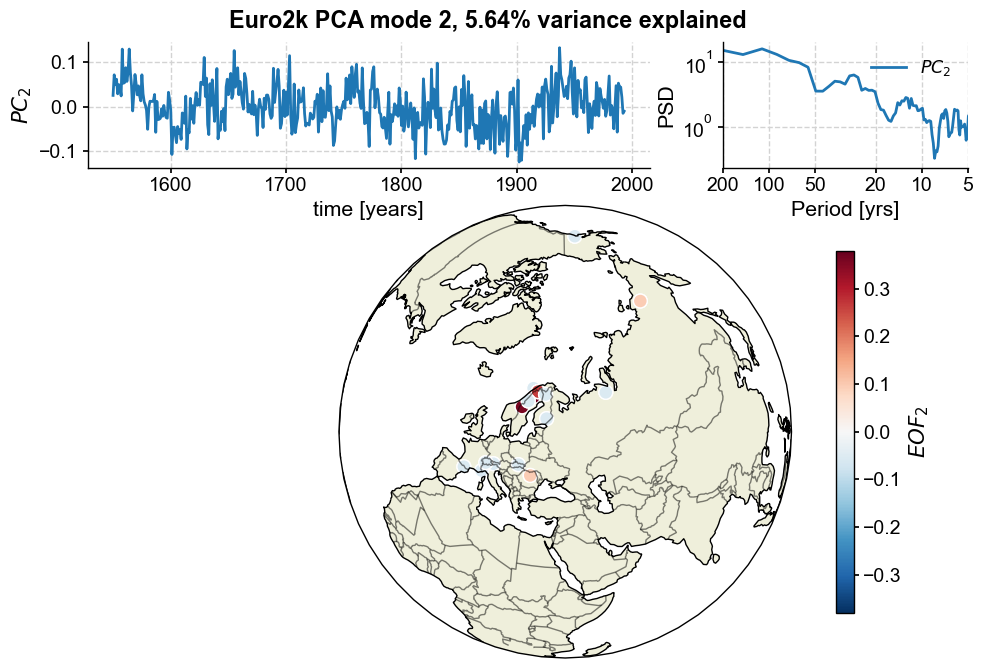

In [45]:
pca.modeplot(index=1, map_kwargs={'projection':'Orthographic'})

This one is more of a mixed bag, with spatial weights both positive and negative, and dominated by two series near the Arctic circle. The spectrum shows evidence of scaling behavior, though with some broadband peaks in the decadal and multidecadal ranges. If you wanted to look at this in more detail, you could place the principal component into a `pyleoclim` Series object and apply the tools of [spectral analysis](L2_spectral_analysis.md):

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:14<00:00, 70.92it/s]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [yrs]', ylabel='PSD'>)

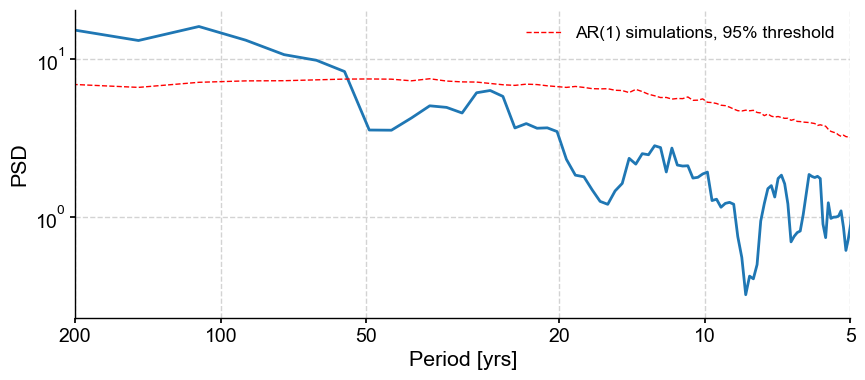

In [43]:
pc2 = pyleo.Series(value=pca.pcs[:,1], verbose=False, 
                   time = Euro2kc.series_list[0].time) # remember Python's zero-based indexing
pc2spec = pc2.spectral(method='mtm').signif_test(number=1000)                 
pc2spec.plot()  

Here, we see that no peak rises above the rednoise background, but the low-frequency part does, which is one would expect for scaling behavior, whose slope we can find very easily:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [yrs]', ylabel='PSD'>)

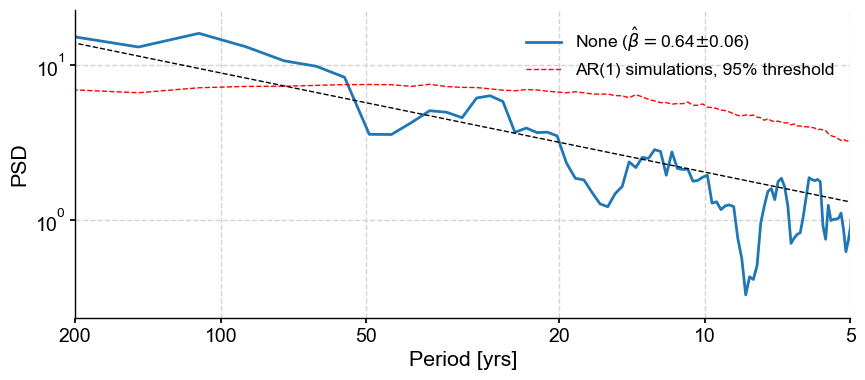

In [44]:
pc2spec.beta_est().plot()

## Monte Carlo PCA
in the works

## Conclusion

This concludes our tutorial on PCA in Pyleoclim. If you have suggestions for additional features or domains of application, feel free to discuss them on our [discourse forum](https://discourse.linked.earth) or to open an [issue on GitHub](https://github.com/LinkedEarth/Pyleoclim_util/issues).